## 0. Install Dependencies

Run this cell once to ensure all required packages are available in the current kernel.

In [14]:
# Install dependencies (run once per kernel)
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
    'boto3', 's3fs', 'pandas', 'numpy', 'matplotlib', 'seaborn',
    'scikit-learn', 'xgboost', 'lightgbm', 'sagemaker', 'pyyaml'])


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


0

# Data Exploration - Fraud Detection Dataset

This notebook demonstrates loading and exploring the fraud detection dataset from S3.
We analyze feature distributions, dataset statistics, and class imbalance to inform
feature engineering and model training decisions.

**Requirements covered:** 2.1 (Load Parquet from S3), 2.2 (Visualization utilities), 2.3 (Statistical summaries), 2.4 (Schema and sample records)

## 1. Setup and Imports

In [15]:
import sys
import io

import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project src to path for ExperimentTracker
sys.path.insert(0, '../src')
from experiment_tracking import ExperimentTracker

sns.set_theme(style='whitegrid')
%matplotlib inline

## 2. Load Data from S3

Load the train, validation, and test Parquet splits from the `fraud-detection-data-<suffix>` S3 bucket.

**Requirement 2.1**: Load Parquet datasets from S3 (train, validation, test splits)

In [16]:
import os
BUCKET_SUFFIX = os.environ.get('BUCKET_SUFFIX', 'quannh0308-20260222')
BUCKET_NAME = f'fraud-detection-data-{BUCKET_SUFFIX}'
DATA_PREFIX = 'prepared'

# Read partitioned Parquet directories directly from S3
train_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/train.parquet/')
val_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/validation.parquet/')
test_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/test.parquet/')

print(f'Train set:      {train_df.shape[0]:>8,} rows, {train_df.shape[1]} columns')
print(f'Validation set: {val_df.shape[0]:>8,} rows, {val_df.shape[1]} columns')
print(f'Test set:       {test_df.shape[0]:>8,} rows, {test_df.shape[1]} columns')

Train set:       199,824 rows, 31 columns
Validation set:   42,646 rows, 31 columns
Test set:         42,337 rows, 31 columns


## 3. Dataset Schema and Sample Records

**Requirement 2.4**: Display dataset schema and sample records

In [17]:
print('=== Dataset Schema ===')
print(f'{"Column":<20} {"Dtype":<15} {"Non-Null Count"}')
print('-' * 55)
for col in train_df.columns:
    non_null = train_df[col].notna().sum()
    print(f'{col:<20} {str(train_df[col].dtype):<15} {non_null}/{len(train_df)}')

=== Dataset Schema ===
Column               Dtype           Non-Null Count
-------------------------------------------------------
Class                int32           199824/199824
Time                 float64         199824/199824
V1                   float64         199824/199824
V2                   float64         199824/199824
V3                   float64         199824/199824
V4                   float64         199824/199824
V5                   float64         199824/199824
V6                   float64         199824/199824
V7                   float64         199824/199824
V8                   float64         199824/199824
V9                   float64         199824/199824
V10                  float64         199824/199824
V11                  float64         199824/199824
V12                  float64         199824/199824
V13                  float64         199824/199824
V14                  float64         199824/199824
V15                  float64         199824/199824
V1

In [18]:
print('=== Sample Records (first 5 rows) ===')
train_df.head()

=== Sample Records (first 5 rows) ===


,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
3,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
4,0,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67


## 4. Statistical Summary

**Requirement 2.3**: Statistical summary functions for dataset characteristics (record counts, missing values, feature ranges)

In [19]:
def dataset_summary(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """Generate a statistical summary for a dataset split.

    Returns a DataFrame with count, missing, min, max, mean, std, and
    median for every column.
    """
    summary = pd.DataFrame({
        'count': df.count(),
        'missing': df.isnull().sum(),
        'missing_pct': (df.isnull().sum() / len(df) * 100).round(2),
        'min': df.min(numeric_only=True),
        'max': df.max(numeric_only=True),
        'mean': df.mean(numeric_only=True).round(4),
        'std': df.std(numeric_only=True).round(4),
        'median': df.median(numeric_only=True).round(4)
    })
    print(f'\n=== {name} Summary ({len(df):,} records) ===')
    return summary


train_summary = dataset_summary(train_df, 'Train')
train_summary


=== Train Summary (199,824 records) ===


,count,missing,missing_pct,min,max,mean,std,median
Class,199824,0,0.0,0.000000,1.000000,0.0017,0.0409,0.0000
Time,199824,0,0.0,0.000000,172792.000000,94761.2844,47503.2268,84623.5000
V1,199824,0,0.0,-56.407510,2.454930,0.0014,1.9604,0.0220
V2,199824,0,0.0,-72.715728,22.057729,-0.0023,1.6555,0.0642
V3,199824,0,0.0,-48.325589,9.382558,-0.0023,1.5165,0.1780
V4,199824,0,0.0,-5.560118,16.715537,0.0010,1.4139,-0.0159
V5,199824,0,0.0,-113.743307,34.801666,0.0003,1.3787,-0.0546
V6,199824,0,0.0,-26.160506,73.301626,0.0003,1.3322,-0.2736
V7,199824,0,0.0,-43.557242,120.589494,-0.0002,1.2427,0.0389
V8,199824,0,0.0,-73.216718,20.007208,-0.0012,1.2012,0.0228


In [20]:
val_summary = dataset_summary(val_df, 'Validation')
val_summary


=== Validation Summary (42,646 records) ===


,count,missing,missing_pct,min,max,mean,std,median
Class,42646,0,0.0,0.000000,1.000000,0.0017,0.0408,0.0000
Time,42646,0,0.0,1.000000,172786.000000,94979.4352,47364.7724,84962.5000
V1,42646,0,0.0,-37.054295,2.439207,-0.0094,1.9786,0.0029
V2,42646,0,0.0,-48.060856,18.902453,0.0065,1.6598,0.0683
V3,42646,0,0.0,-33.680984,3.934739,0.0002,1.5299,0.1820
V4,42646,0,0.0,-5.071655,12.672760,-0.0095,1.4141,-0.0419
V5,42646,0,0.0,-40.427726,34.099309,-0.0023,1.3982,-0.0583
V6,42646,0,0.0,-23.496714,23.917837,-0.0036,1.3382,-0.2771
V7,42646,0,0.0,-26.548144,44.054461,0.0011,1.2407,0.0437
V8,42646,0,0.0,-41.484823,18.329406,0.0021,1.1768,0.0236


In [21]:
test_summary = dataset_summary(test_df, 'Test')
test_summary


=== Test Summary (42,337 records) ===


,count,missing,missing_pct,min,max,mean,std,median
Class,42337,0,0.0,0.000000,1.000000,0.0020,0.0450,0.0000
Time,42337,0,0.0,4.000000,172782.000000,94895.2219,47541.6601,84822.0000
V1,42337,0,0.0,-35.698345,2.422508,0.0027,1.9305,0.0091
V2,42337,0,0.0,-60.464618,19.167239,0.0042,1.6226,0.0693
V3,42337,0,0.0,-32.965346,3.985446,0.0108,1.5010,0.1850
V4,42337,0,0.0,-5.683171,16.875344,0.0047,1.4271,-0.0171
V5,42337,0,0.0,-27.752964,29.016124,0.0009,1.3694,-0.0503
V6,42337,0,0.0,-20.054615,18.072031,0.0022,1.3269,-0.2742
V7,42337,0,0.0,-37.060311,28.504065,-0.0003,1.2067,0.0430
V8,42337,0,0.0,-50.688419,18.748872,0.0036,1.1792,0.0182


## 5. Feature Distribution Visualizations

**Requirement 2.2**: Visualization utilities for feature distributions, correlations, and class imbalance analysis

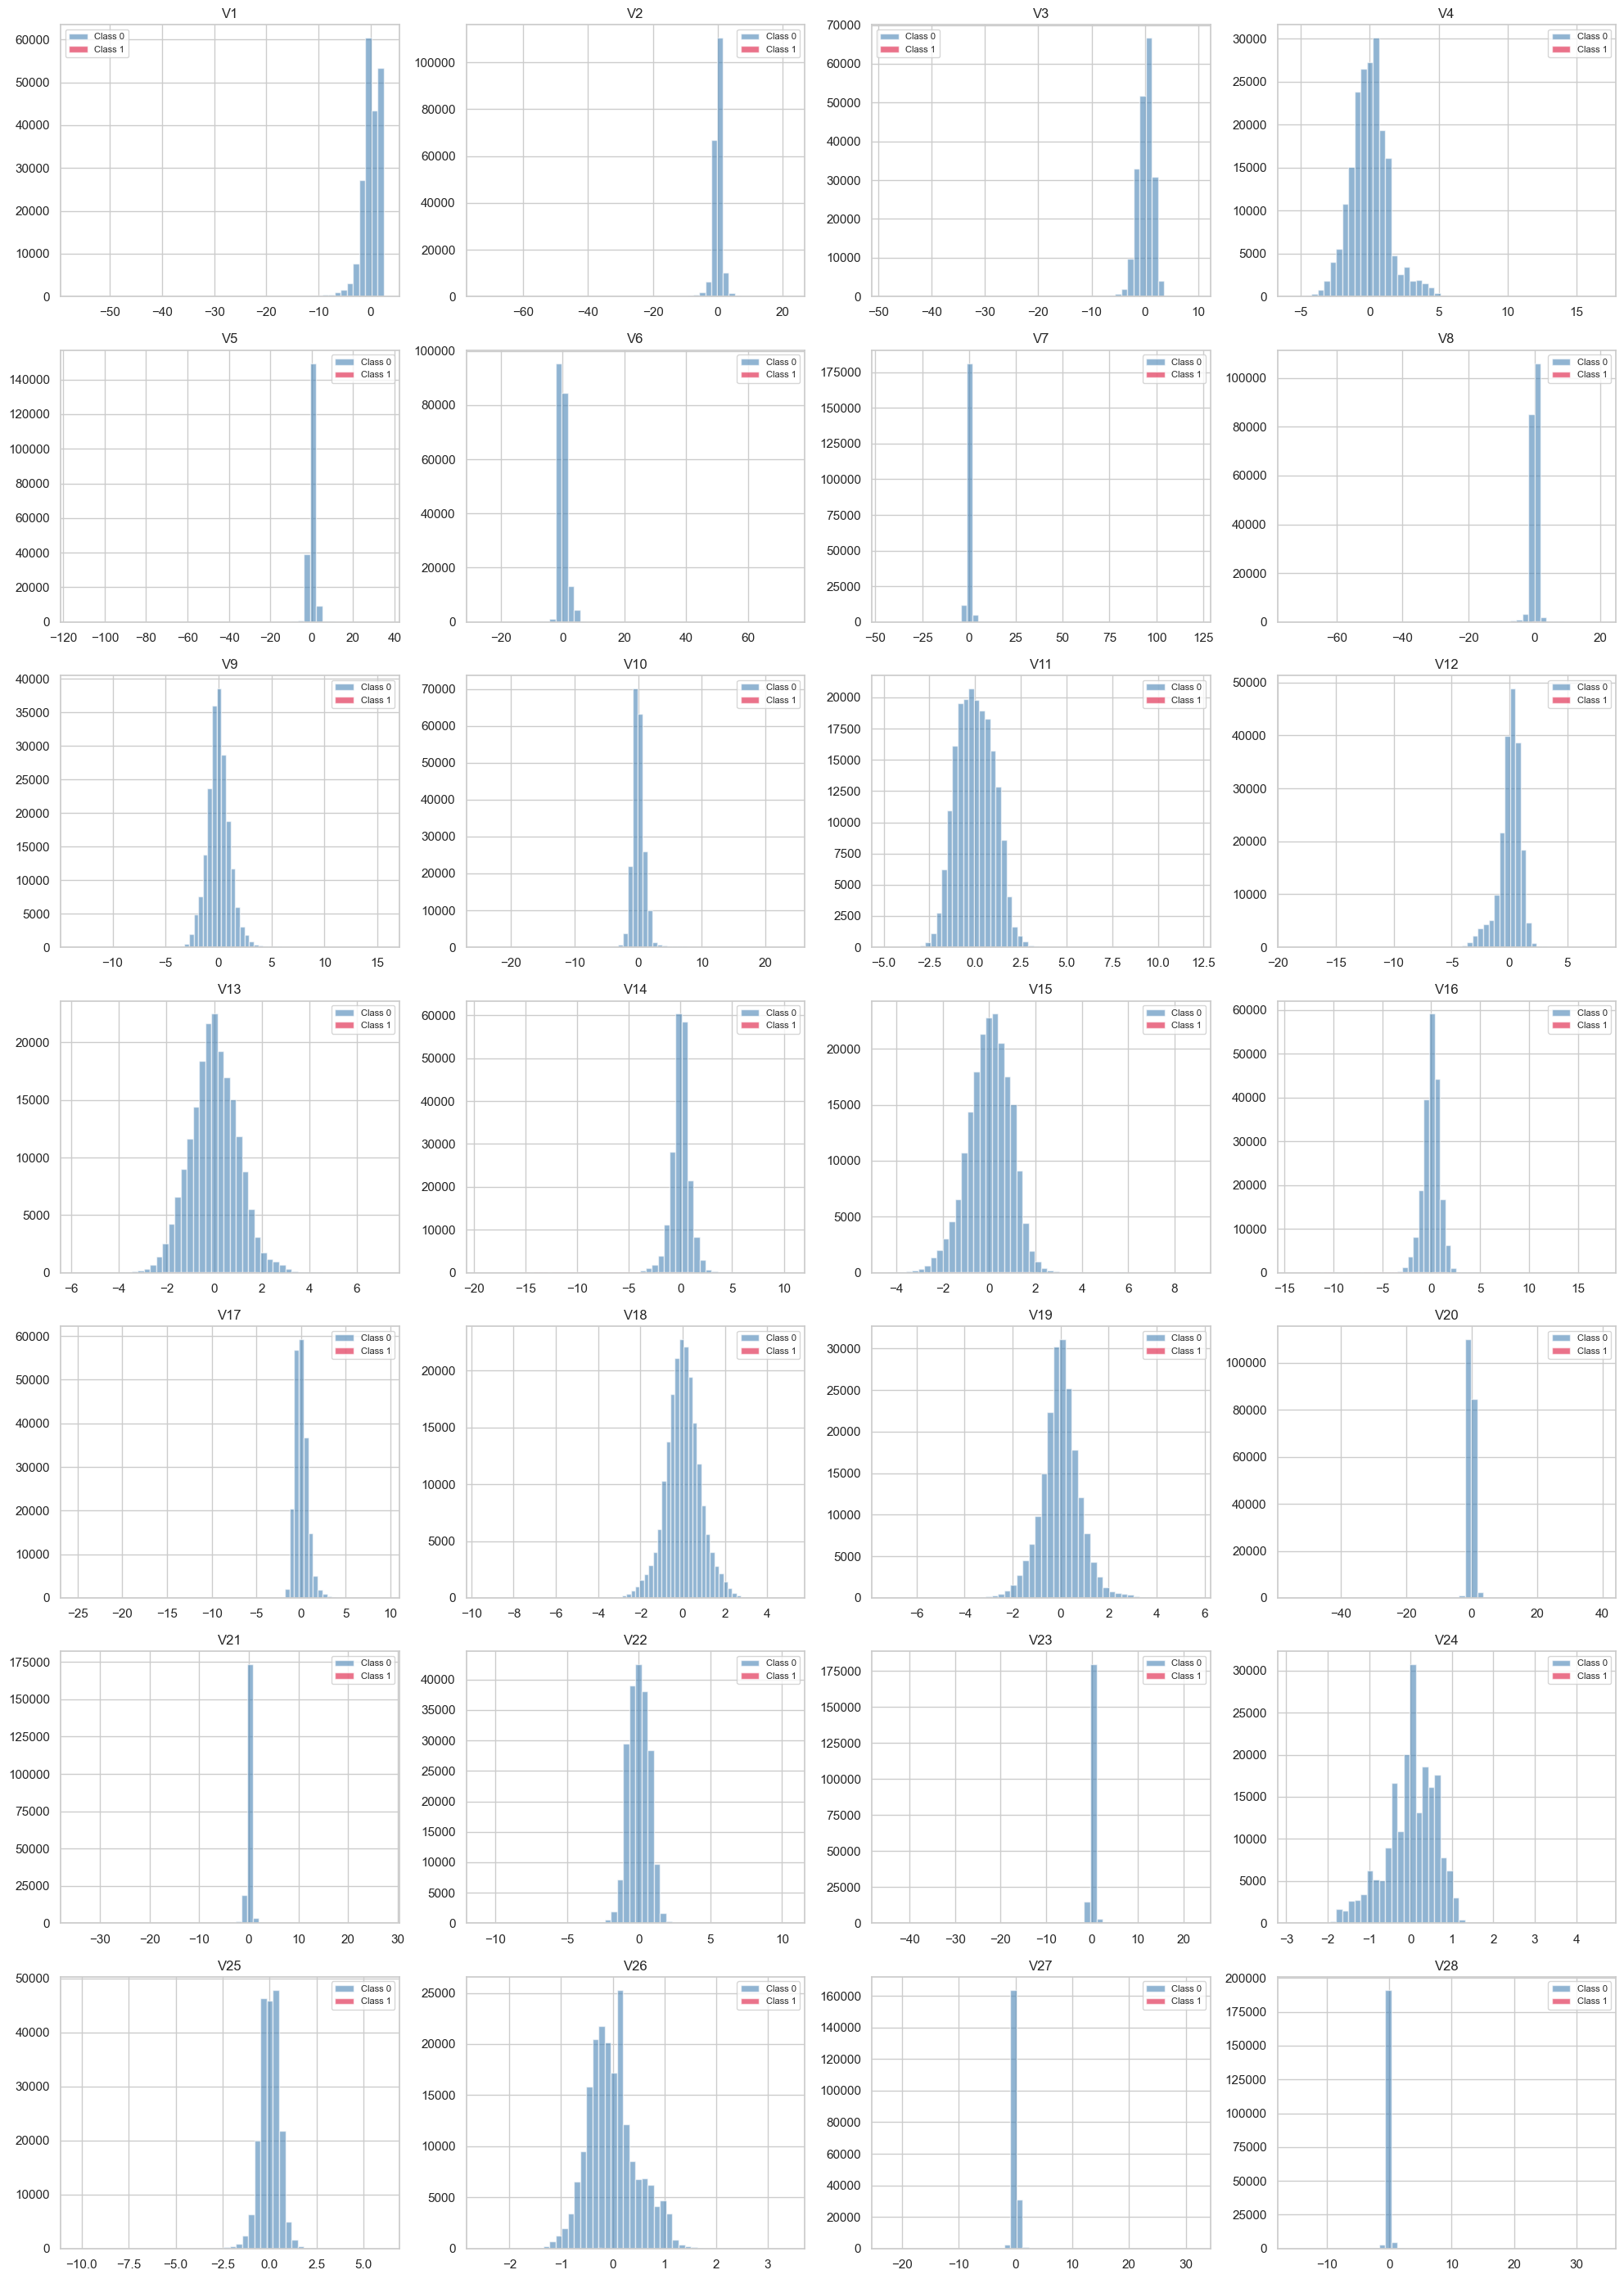

In [22]:
def plot_feature_distributions(df: pd.DataFrame, features: list, ncols: int = 4) -> None:
    """Plot histograms for the given features, coloured by Class label."""
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for idx, feat in enumerate(features):
        ax = axes[idx]
        for label, colour in [(0, 'steelblue'), (1, 'crimson')]:
            subset = df[df['Class'] == label][feat]
            ax.hist(subset, bins=50, alpha=0.6, label=f'Class {label}', color=colour)
        ax.set_title(feat)
        ax.legend(fontsize=8)

    # Hide unused axes
    for idx in range(len(features), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()


# Plot PCA features V1-V28
pca_features = [f'V{i}' for i in range(1, 29)]
plot_feature_distributions(train_df, pca_features)

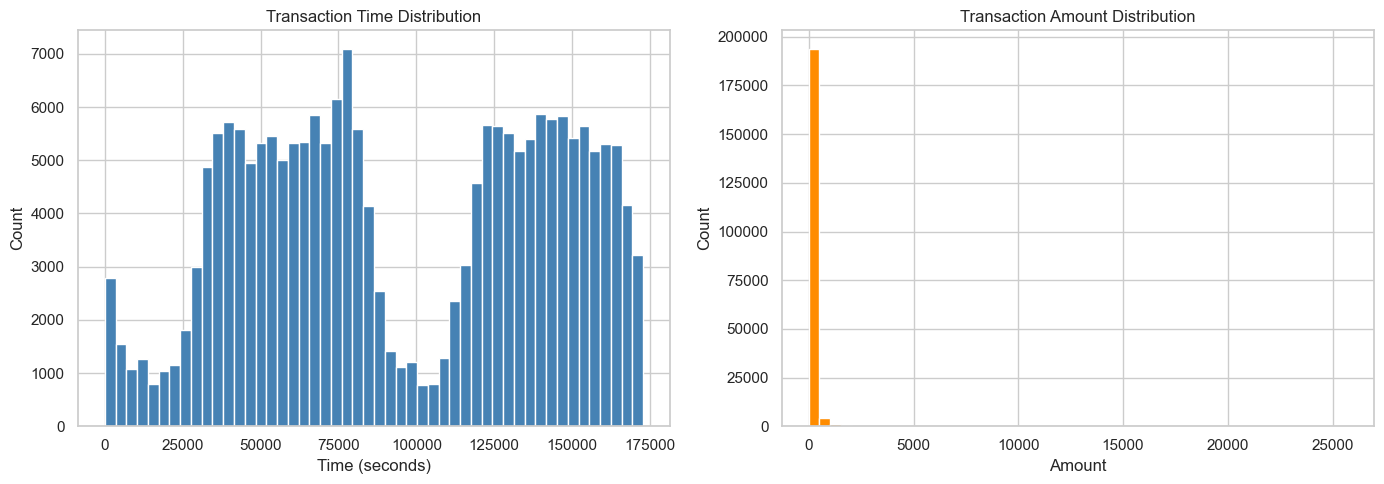

In [23]:
# Distribution of Time and Amount
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df['Time'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Transaction Time Distribution')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Count')

axes[1].hist(train_df['Amount'], bins=50, color='darkorange', edgecolor='white')
axes[1].set_title('Transaction Amount Distribution')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### 5.1 Feature Correlation Heatmap

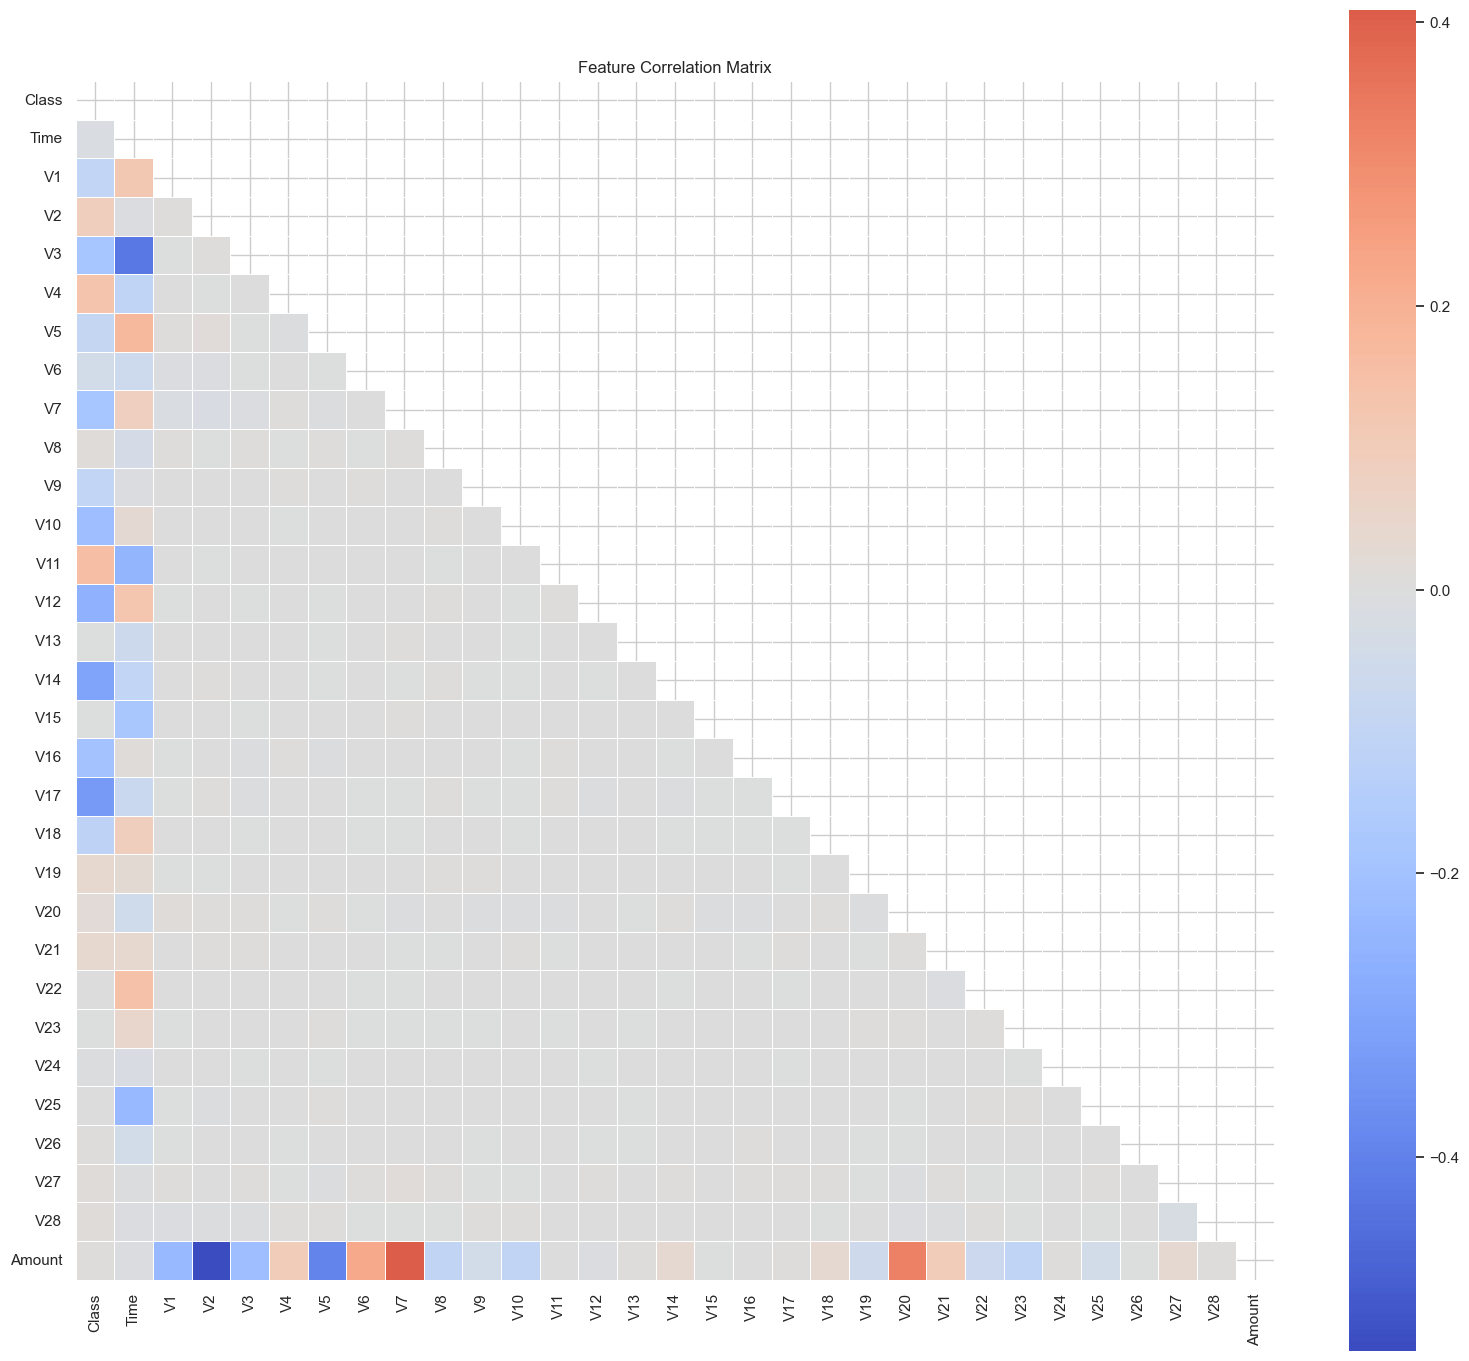

In [24]:
def plot_correlation_heatmap(df: pd.DataFrame, title: str = 'Feature Correlation Matrix') -> None:
    """Plot a correlation heatmap for all numeric features."""
    corr = df.select_dtypes(include=[np.number]).corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(16, 14))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
                linewidths=0.5, fmt='.2f', square=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_correlation_heatmap(train_df)

### 5.2 Top Correlated Features with Target

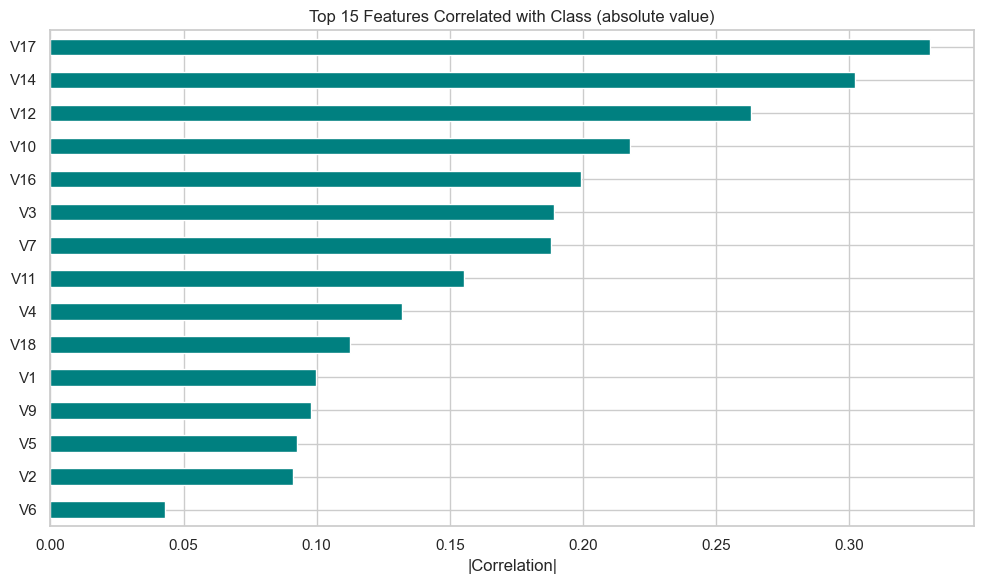

In [25]:
target_corr = train_df.select_dtypes(include=[np.number]).corr()['Class'].drop('Class').abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
target_corr.head(15).plot(kind='barh', color='teal')
plt.title('Top 15 Features Correlated with Class (absolute value)')
plt.xlabel('|Correlation|')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Class Imbalance Analysis

Fraud detection datasets are typically highly imbalanced. Understanding the class
distribution is critical for choosing the right evaluation metrics and sampling strategies.

In [26]:
def analyze_class_imbalance(df: pd.DataFrame, name: str) -> dict:
    """Analyze and visualize class distribution.

    Returns a dict with counts, percentages, and imbalance ratio.
    """
    counts = df['Class'].value_counts().sort_index()
    total = len(df)
    legit = int(counts.get(0, 0))
    fraud = int(counts.get(1, 0))
    ratio = legit / fraud if fraud > 0 else float('inf')

    print(f'=== {name} Class Distribution ===')
    print(f'  Legitimate (0): {legit:>8,}  ({legit/total*100:.2f}%)')
    print(f'  Fraud      (1): {fraud:>8,}  ({fraud/total*100:.2f}%)')
    print(f'  Imbalance ratio: {ratio:.1f}:1')

    return {'legitimate': legit, 'fraud': fraud, 'ratio': ratio}


train_imbalance = analyze_class_imbalance(train_df, 'Train')
val_imbalance = analyze_class_imbalance(val_df, 'Validation')
test_imbalance = analyze_class_imbalance(test_df, 'Test')

=== Train Class Distribution ===
  Legitimate (0):  199,489  (99.83%)
  Fraud      (1):      335  (0.17%)
  Imbalance ratio: 595.5:1
=== Validation Class Distribution ===
  Legitimate (0):   42,575  (99.83%)
  Fraud      (1):       71  (0.17%)
  Imbalance ratio: 599.6:1
=== Test Class Distribution ===
  Legitimate (0):   42,251  (99.80%)
  Fraud      (1):       86  (0.20%)
  Imbalance ratio: 491.3:1


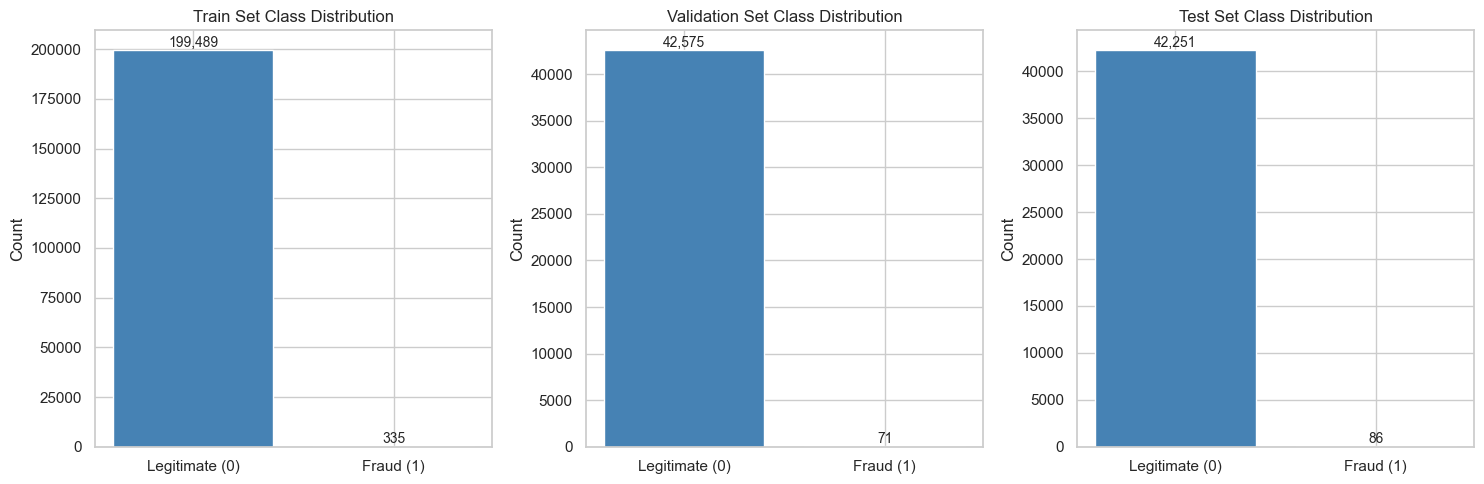

In [27]:
# Visualize class distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (df, name) in zip(axes, [(train_df, 'Train'), (val_df, 'Validation'), (test_df, 'Test')]):
    counts = df['Class'].value_counts().sort_index()
    colors = ['steelblue', 'crimson']
    bars = ax.bar(['Legitimate (0)', 'Fraud (1)'], counts.values, color=colors)
    ax.set_title(f'{name} Set Class Distribution')
    ax.set_ylabel('Count')
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

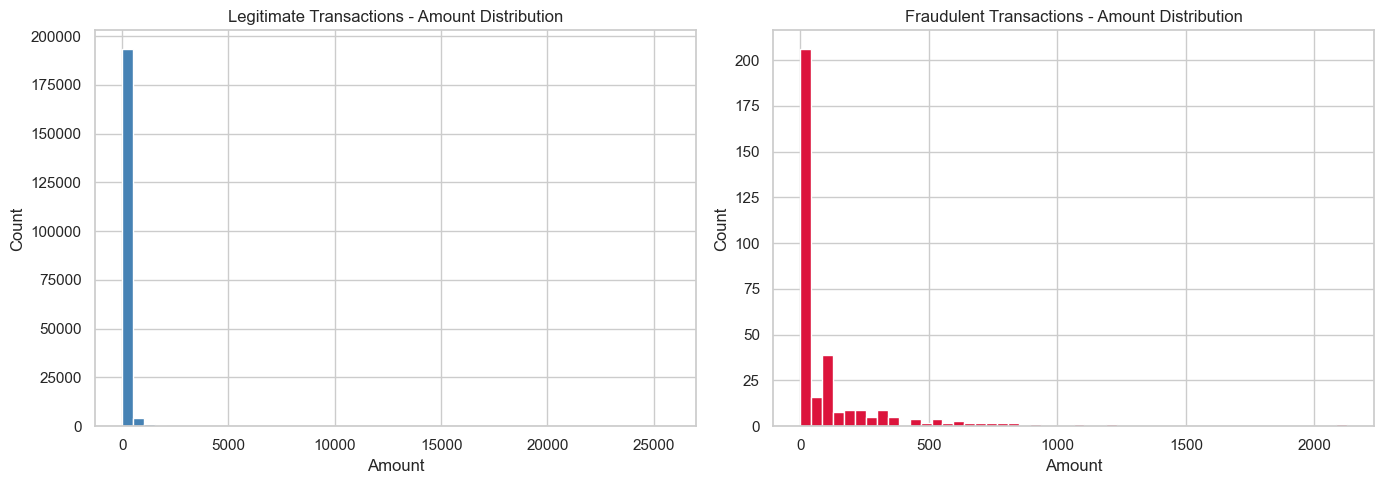

In [28]:
# Amount distribution by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, label, title in zip(axes, [0, 1], ['Legitimate Transactions', 'Fraudulent Transactions']):
    subset = train_df[train_df['Class'] == label]['Amount']
    ax.hist(subset, bins=50, color='steelblue' if label == 0 else 'crimson', edgecolor='white')
    ax.set_title(f'{title} - Amount Distribution')
    ax.set_xlabel('Amount')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 7. Log Exploration to ExperimentTracker

Record the data exploration session so it is tracked alongside model experiments.

In [29]:
tracker = ExperimentTracker(region_name='us-east-1')

experiment_id = tracker.start_experiment(
    experiment_name='fraud-detection-data-exploration',
    algorithm='data-exploration',
    user='data-scientist',
    dataset_version='v1.0',
    code_version='notebook-01'
)

tracker.log_parameters(experiment_id, {
    'train_rows': int(train_df.shape[0]),
    'val_rows': int(val_df.shape[0]),
    'test_rows': int(test_df.shape[0]),
    'num_features': int(train_df.shape[1]),
    'bucket': BUCKET_NAME
})

tracker.log_metrics(experiment_id, {
    'train_fraud_ratio': train_imbalance['ratio'],
    'train_fraud_count': float(train_imbalance['fraud']),
    'train_legit_count': float(train_imbalance['legitimate']),
    'missing_values_total': float(train_df.isnull().sum().sum())
})

tracker.close_experiment(experiment_id)

print(f'Exploration logged as experiment: {experiment_id}')

Exploration logged as experiment: data-exploration-20260222-204932-ac14c48b


## Summary

Key observations from data exploration:

1. **Schema**: The dataset contains Time, Amount, V1-V28 (PCA features), and Class columns.
2. **Class imbalance**: Fraud cases are a small minority — consider oversampling, SMOTE, or class-weight adjustments during training.
3. **Feature correlations**: Several V-features show meaningful correlation with the target, which can guide feature selection.
4. **Amount distribution**: Fraudulent transactions tend to have different amount patterns than legitimate ones.

Next steps: proceed to feature engineering (notebook 04) or hyperparameter tuning (notebook 02).